In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from fontTools.misc.bezierTools import epsilon
from scipy import stats
import random
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)
def laplace_mech_vec(vec, sensitivity, epsilon):
    return [v + np.random.laplace(loc=0, scale=sensitivity / epsilon) for v in vec]

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0


In [2]:
# Load the data and libraries
import pandas as pd
import numpy as np

bear = pd.read_csv('https://raw.githubusercontent.com/jbennett979/Data_Privacy_FP/refs/heads/main/north_america_bear_killings.csv')

In [3]:
#removing space from the column name age\n",
bear.columns = [c.lstrip() for c in bear]
# capitalizing columns name for age and gende
bear= bear.rename(columns={'age': 'Age'})
bear= bear.rename(columns={'gender': 'Gender'})

In [4]:
print(bear.columns)
    # converting the age column who was a string to integers
bear['Age'] = pd.to_numeric(bear['Age'], errors = 'coerce')

Index(['Name', 'Age', 'Gender', 'Date', 'Month', 'Year', 'Type', 'Location',
       'Description', 'Type of bear', 'Hunter', 'Grizzly', 'Hikers',
       'Only one killed'],
      dtype='object')


In [5]:
def age_sum (epsilon):
   b = 75
   clipped_sum = bear['Age'].clip(upper=b).sum()

   return (laplace_mech(clipped_sum, sensitivity=b, epsilon=epsilon))

age_sum(1.0)

np.float64(5816.218911753079)

In [6]:
def dp_avg_age(epsilon):

    noisy_sum = age_sum(epsilon/2)

    noisy_count = laplace_mech(len(bear), sensitivity=1, epsilon=epsilon/2)

    mean = noisy_sum/noisy_count

    return mean

dp_avg_age(1.0)

np.float64(35.7308703206526)

In [7]:
# starting with choosing a clip param using clip b param for age

def pick_b_avg(epsilon):
   bs =  range(1,200,10)
   last_result = 0
   epsilon_i = epsilon / len(bs)

   for b in bs:
    #try b
    clipped_sum = bear['Age'].clip(upper=b).sum()
    noisy_sum= (laplace_mech(clipped_sum, sensitivity=b, epsilon=epsilon_i))
    noisy_count = laplace_mech(len(bear), sensitivity=1, epsilon=epsilon/2)
    result= noisy_sum / noisy_count


    if result < last_result:
        return b
    else:
        last_result = result
    #raise Exception('No good clipping parameter found')
pick_b_avg(1.0)

61

In [8]:
# differential private
def monthly_counts (epsilon):

   count= bear['Month'].value_counts()

   return (laplace_mech(count, sensitivity=1, epsilon=epsilon))

monthly_counts(1.0)

Month
8     28.256692
7     27.256692
10    24.256692
9     24.256692
6     20.256692
5     18.256692
11    12.256692
4      4.256692
1      3.256692
12     2.256692
2      1.256692
3      1.256692
Name: count, dtype: float64

In [9]:
# differential private
def year_counts (epsilon):

   count= bear['Year'].value_counts()

   return (laplace_mech(count, sensitivity=1, epsilon=epsilon))

year_counts(1.0)

Year
1980    7.304452
2005    7.304452
2018    6.304452
1983    5.304452
1992    5.304452
          ...   
1930    1.304452
1922    1.304452
1916    1.304452
1908    1.304452
1906    1.304452
Name: count, Length: 74, dtype: float64

In [10]:
# range queries
def range_query(df, col, a, b):
    return len(df[(df[col] >= a) & (df[col] < b)]) # this runs the range query

random_lower_bounds = [random.randint(1, 70) for _ in range(100)]
random_workload = [(lb, random.randint(lb, 100)) for lb in random_lower_bounds]
real_answers = [range_query(bear, 'Age', lb, ub) for (lb, ub) in random_workload]

In [11]:
def workload_laplace_vec(workload, epsilon):
    l1_sens = len(workload)
    workload_answer = [range_query(bear, 'Age', lb, ub) for (lb, ub) in random_workload]
    laplace_vec=  laplace_mech_vec(workload_answer, l1_sens, epsilon=epsilon)
    return laplace_vec
print('First 4 answers:', workload_laplace_vec(random_workload, 1.0)[:4])

First 4 answers: [-19.00104325185555, 228.64383656243166, 300.52336737902465, 57.526656061361756]


In [12]:
errors_1 = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_laplace_vec(random_workload, 1.0))]
print('Average absolute error:', np.mean(errors_1))
assert np.mean(errors_1) > 20
assert np.mean(errors_1) < 150

Average absolute error: 99.63863664257056


In [13]:
# Renyi DP
def workload_gaussian_vec_RDP(workload, alpha, epsilon_bar):

    def gaussian_mech_RDP_vec(vec, sensitivity, alpha, epsilon):
        sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
        return [v + np.random.normal(loc=0, scale=sigma) for v in vec]

    sensitivity = np.sqrt(len(workload))
    answers = gaussian_mech_RDP_vec([range_query(bear, 'Age', lb, ub) for (lb, ub) in workload],
                                    sensitivity, alpha, epsilon_bar)
    return answers

In [14]:
#conversion
def convert_RDP_ED(alpha, epsilon_bar, delta):
   new_epsilon = epsilon_bar + np.log(1/delta) / (alpha-1)
   return new_epsilon

convert_RDP_ED(5, 1.0, 1e-5)

np.float64(3.878231366242557)

In [15]:
#passing the converted epsilon for the average error of RDP
converted_epsilon = convert_RDP_ED(5,1.0, 1e-5)
errors_2 = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_gaussian_vec_RDP(random_workload, alpha=1.0, epsilon_bar= converted_epsilon))]
print('Average absolute error:', np.mean(errors_2))
assert np.mean(errors_2) > 1
assert np.mean(errors_2) < 100

Average absolute error: 2.6116209606811616


In [16]:
# Gaussian mech
def workload_gaussian_vec(workload, epsilon, delta):
    sensitivity = np.sqrt(len(workload))
    workload_answer = [range_query(bear, 'Age', lb, ub) for (lb, ub) in random_workload]
    gaussian_vec= gaussian_mech_vec(workload_answer, sensitivity=sensitivity, epsilon=epsilon , delta=delta)
    return gaussian_vec

In [17]:
errors_3 = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_gaussian_vec(random_workload,converted_epsilon, 0.1))]
print('Average absolute error:', np.mean(errors_3))
assert np.mean(errors_3) > 1
assert np.mean(errors_3) < 100

# for renyy do the conversion , covert epsilon t
# set my epsilon bar = 1.0
# alpha to 5
# 2 set esplon to the conversion
# run both mechanisms
#rdp first and gaussian use the result of mech conversipn to do the gaussian.
# what did we learn about the data
# run on all of the columns on the loop instead of age by itself
#how epsilon on x axis , percent error on y , maybe having to show how it represents


Average absolute error: 4.18009901211664


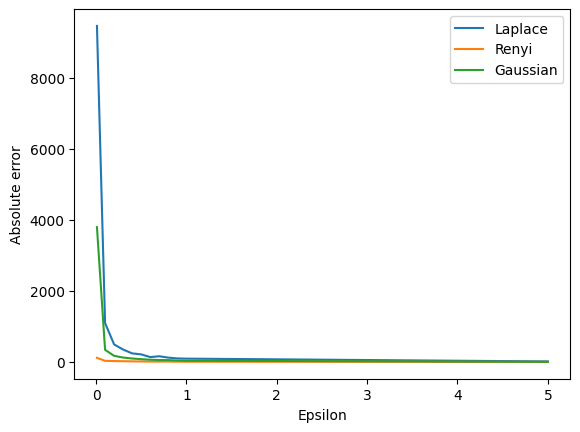

In [18]:
def graphing():
    epsilon_list = [0.01,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0]
    errors_lp = []
    errors_rdp = []
    errors_g = []
    for epsilon in epsilon_list:
        alpha = 5
    #Laplace mechanism
        errors_1 = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_laplace_vec(random_workload, epsilon))]
        errors_lp.append(np.mean(errors_1))

    # Renyi
        errors_2= [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_gaussian_vec_RDP(random_workload, alpha=alpha, epsilon_bar=epsilon))]
        errors_rdp.append(np.mean(errors_2))

    #Gaussian
        errors_3 = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers,workload_gaussian_vec(random_workload, epsilon, delta = 1e-5))]
        errors_g.append(np.mean(errors_3))


    plt.plot(epsilon_list, errors_lp, label='Laplace')
    plt.plot(epsilon_list, errors_rdp, label='Renyi')
    plt.plot(epsilon_list, errors_g, label='Gaussian')
    plt.xlabel('Epsilon')
    plt.ylabel('Absolute error')
    plt.legend()
    plt.show()

graphing()


In [20]:
# Load data files
import numpy as np
import urllib.request
import io

x_pre = bear[['Age', 'Month', 'Year', 'Grizzly', 'Hikers', 'Only one killed']].copy()
y_pre = bear['Hunter']

#x_pre.loc[:, ['Grizzly', 'Hikers', 'Only one killed']] = x_pre[['Grizzly', 'Hikers', 'Only one killed']].replace(0, -1)
y_pre = y_pre.replace(0, -1)

X = x_pre.to_numpy()
y = y_pre.to_numpy()


In [21]:
# Split data into training and test sets
training_size = int(X.shape[0] * 0.8)

X_train = X[:training_size]
X_test = X[training_size:]

y_train = y[:training_size]
y_test = y[training_size:]

print('Train and test set sizes:', len(y_train), len(y_test))


Train and test set sizes: 131 33


In [22]:
# This is the gradient of the logistic loss
# The gradient is a vector that indicates the rate of change of the loss in each direction
def gradient(theta, xi, yi):
    exponent = yi * (xi.dot(theta))
    exponent = np.clip(exponent, -500, 500)
    return - (yi*xi) / (1+np.exp(exponent))

def predict(xi, theta, bias=0):
    label = np.sign(xi @ theta + bias)
    return label

def accuracy(theta):
    return np.sum(predict(X_test, theta) == y_test)/X_test.shape[0]

def L2_clip(v, b):
    norm = np.linalg.norm(v, ord=2)
    
    if norm > b:
        return b * (v / norm)
    else:
        return v

def gradient_sum(theta, X, y, b):
    gradients = [L2_clip(gradient(theta, x_i, y_i), b) for x_i, y_i in zip(X,y)]
        
    # sum query
    # L2 sensitivity is b (by clipping performed above)
    return np.sum(gradients, axis=0)
   

def noisy_gradient_descent(iterations, epsilon, delta):
    theta = np.zeros(X_train.shape[1])
    b = 3

    noisy_count = laplace_mech(X_train.shape[0], 1, epsilon)

    for i in range(iterations):
        clipped_gradient_sum = gradient_sum(theta, X_train, y_train, b)
        noisy_gradient_sum = np.array(gaussian_mech_vec(clipped_gradient_sum, b, epsilon, delta))
        noisy_avg_gradient = noisy_gradient_sum / noisy_count
        theta = theta - noisy_avg_gradient

    return theta

theta = noisy_gradient_descent(10, 10.0, 1e-5)
print('Final accuracy:', accuracy(theta))

Final accuracy: 0.09090909090909091


In [23]:
def gaussian_mech_RDP_vec(vec, sensitivity, alpha, epsilon):
    sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
    return [v + np.random.normal(loc=0, scale=sigma) for v in vec]

def noisy_gradient_descent_RDP(iterations, alpha, epsilon_bar):
    theta = np.random.normal(size=X_train.shape[1])
    b = 3
    epsilon_bar_count = 0.05 * epsilon_bar
    epsilon_bar_i = 0.95 * epsilon_bar / iterations
    
    noisy_count = gaussian_mech_RDP_vec([len(X_train)], 1, alpha, epsilon_bar_count)[0]

    for i in range(iterations):
        clipped_gradient_sum = gradient_sum(theta, X_train, y_train, b)
        noisy_gradient_sum = np.array(gaussian_mech_RDP_vec(clipped_gradient_sum, b, alpha, epsilon_bar_i))
        noisy_avg_gradient = noisy_gradient_sum / noisy_count
        theta = theta - noisy_avg_gradient

    return theta

theta = noisy_gradient_descent_RDP(10, 20, 0.1)
print('Final accuracy:', accuracy(theta))

Final accuracy: 0.9090909090909091


In [26]:
def gaussian_mech_zCDP_vec(vec, sensitivity, rho):
    sigma = np.sqrt((sensitivity**2) / (2 * rho))
    return [v + np.random.normal(loc=0, scale=sigma) for v in vec]

def noisy_gradient_descent_zCDP(iterations, rho):
    theta = np.random.normal(size=X_train.shape[1])
    noisy_count = gaussian_mech_zCDP_vec(pd.Series([len(X_train)]), sensitivity=1, rho=rho)
    for i in range(iterations):
        grads = [gradient(theta, x_i, y_i) for x_i, y_i in zip(X_train, y_train)]
        b = 3 # clipping parameter (for the L2)
        clipped_grads = [L2_clip(g, b) for g in grads]
        sum_grad = np.sum(clipped_grads, axis=0)
        noisy_sum = gaussian_mech_zCDP_vec(sum_grad, sensitivity=b, rho=rho)
        noisy_grad = np.array(noisy_sum) / noisy_count
        theta = theta - noisy_grad
    return theta

theta = noisy_gradient_descent_zCDP(10, 1)
print('Final accuracy:', accuracy(theta))

Final accuracy: 0.9090909090909091


## Generate synthetic data using private marginals

#### Clean and get dataset and include important functions and packages

In [27]:
bear = pd.read_csv('https://raw.githubusercontent.com/jbennett979/Data_Privacy_FP/refs/heads/main/north_america_bear_killings.csv')

In [28]:
# Cleaning up the dataset
bear.columns = [c.lstrip() for c in bear]
# capitalizing columns name for age and gender
bear= bear.rename(columns={'age': 'Age'})
bear= bear.rename(columns={'gender': 'Gender'})
bear = bear.rename(columns={'Type': 'Captivity'})

bear['Age'] = pd.to_numeric(bear['Age'], errors = 'coerce')
bear

,Name,Age,Gender,Date,Month,Year,Captivity,Location,Description,Type of bear,Hunter,Grizzly,Hikers,Only one killed
0,Erin Johnson,27,female,6/19/2017,6,2017,Wild,"Pogo mine, Alaska","Johnson, a contract employee for Pogo Mine, wa...",Black bear,0,0,0,1
1,Patrick Cooper,16,male,6/18/2017,6,2017,Wild,"Indian, Alaska",Cooper was chased and mauled by a bear while r...,Black bear,0,0,0,1
2,Daniel Ward O'Connor,27,male,5/10/2015,5,2015,Wild,"near Mackenzie, British Columbia",Ward was killed by a bear while he slept near ...,Black bear,0,0,0,1
3,Darsh Patel,22,male,9/21/2014,9,2014,Wild,"near West Milford, New Jersey",Patel was about to begin hiking with four frie...,Black bear,0,0,1,1
4,Lorna Weafer,36,female,5/7/2014,5,2014,Wild,"near Fort McMurray, Alberta","Weafer, a Suncor worker was attacked at the re...",Black bear,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,Baby Laird,1,NaN,10/5/1908,10,1908,Captive,"Tucson, Arizona",After a bear escaped from a cage at Elysian Gr...,Black bear,0,0,0,1
160,John Dicht,18,male,11/24/1906,11,1906,Wild,"Elk County, Pennsylvania","Thinking the bear was dead, Dicht began skinni...",Black bear,0,0,0,1
161,Mary Porterfield,3,female,5/19/1901,5,1901,Wild,"Job, West Virginia",The children were gathering flowers near their...,Black bear,0,0,0,0
162,Wilie Porterfield,5,male,5/19/1901,5,1901,Wild,"Job, West Virginia",The children were gathering flowers near their...,Black bear,0,0,0,0


#### Functions to generate differentially private marginals

In [29]:
# calculates a differentially private one-way marginal for a given column
def dp_marginal(col, epsilon):
    hist = bear[col].value_counts()
    dp_hist = hist.apply(lambda x: laplace_mech(x, 1, epsilon))
    clipped = dp_hist.clip(lower=0)
    marginal = clipped / clipped.sum()
    return marginal

In [30]:
# one-way marginal for the age column
age_marg = dp_marginal('Age', 1.0)
hist = bear['Age'].value_counts() / len(bear['Age'])
df = pd.merge(hist, age_marg, on='Age').rename(columns={'count_x': 'Real_Age', 'count_y': 'Synth_Age'})
df['% Error'] = df.apply(lambda x: pct_error(x.Real_Age, x.Synth_Age), axis=1)
df
# age_marg

,Real_Age,Synth_Age,% Error
Age,,,
40,0.048780,0.049077,0.608525
24,0.036585,0.032762,10.450675
19,0.036585,0.028110,23.166365
37,0.036585,0.056377,54.098073
31,0.030488,0.027990,8.192027
...,...,...,...
23,0.006098,0.006603,8.285430
43,0.006098,0.003222,47.151734
8,0.006098,0.007759,27.254636


In [31]:
# one-way marginal for the type of bear column
dp_marginal('Type of bear', 1.0)

Type of bear
Brown bear    0.493809
Black bear    0.471069
Polar Bear    0.035122
Name: count, dtype: float64

In [32]:
# one-way marginal for if bear is a grizzly
dp_marginal('Grizzly', 1.0)

Grizzly
0    0.841438
1    0.158562
Name: count, dtype: float64

#### Generate synthetic data from one-way marginal

In [33]:
def gen_samples(n, marginal):
    samples = marginal.sample(n=n, replace=True, weights='probability')
    return samples.drop(columns='probability')

def dp_synthetic_data(cols, n, epsilon):
    epsilon_i = epsilon / len(cols)
    data_dict = {}

    for col in cols:
        marg = dp_marginal(col, epsilon_i).to_frame(name='probability')
        synth = marg.sample(n=n, replace=True, weights='probability').sort_index()

        synth = synth.index.to_series().reset_index(drop=True)
        data_dict[col] = synth

    return pd.concat(data_dict, axis=1)

dp_synthetic_data(['Age'], 20, 1.0)

,Age
0,4
1,5
2,7
3,11
4,18
5,20
6,32
7,32
8,32
9,33


#### Generate two-way marginals

In [34]:
# Generate a two way synthetic rep for age and type of bear
def two_way_bear_hist(col1, col2, epsilon):
    hist = bear[[col1, col2]].value_counts()
    dp_hist = hist.apply(lambda x: laplace_mech(x, sensitivity=1, epsilon=epsilon))
    return dp_hist.clip(lower=0)

def two_marginal(col1, col2, epsilon):
    syn_rep = two_way_bear_hist(col1, col2, epsilon)
    marginal = syn_rep / syn_rep.sum()
    return marginal.to_frame(name='probability').reset_index()

def gen_samples(n, marginal):
    samples = marginal.sample(n=n, replace=True, weights='probability')
    return samples.drop(columns='probability')

In [35]:
# two way marginal
marginal = two_marginal('Type of bear','Age', 1.0)
marginal

,Type of bear,Age,probability
0,Brown bear,40,0.050384
1,Black bear,24,0.002278
2,Brown bear,19,0.024367
3,Black bear,3,0.024878
4,Brown bear,38,0.013443
...,...,...,...
91,Polar Bear,29,0.002875
92,Polar Bear,31,0.005777
93,Polar Bear,43,0.000809
94,Polar Bear,46,0.013709


In [36]:
# two way marginal
marginal = two_marginal('Hunter','Age', 1.0)
gen_samples(15, marginal)

,Hunter,Age
29,1,53
56,0,39
55,0,43
19,0,12
39,0,59
2,0,18
61,0,71
30,0,46
44,1,40
7,0,31


#### Synthetic data with two-way marginals

In [37]:
def dp_synthetic_data_two_marginal(col1, col2, n, epsilon):
    # Age and type marginal
    age_type_marg = two_marginal(col1, col2, epsilon)

    samples = gen_samples(n, age_type_marg).sort_index()
    return samples

In [39]:
""" Synthetic data if the bear was a grizzly and the month the accident occurred """
# 160 samples to better compare the counts
synth = dp_synthetic_data_two_marginal('Grizzly', 'Month', 160, 1.0)

synth_month = len(synth[synth['Month'] == 7])
real_month = len(bear[bear['Month'] == 7])

print(f"Synthetic: {synth_month}, Real: {real_month}")

Synthetic: 22, Real: 27


In [40]:
""" Synthetic data on type of bear and if they were in captivity """
# 160 samples to better compare the counts
synth = dp_synthetic_data_two_marginal('Type of bear', 'Captivity', 160, 1.0)

synth_wild = len(synth[synth['Captivity'] == 'Captive'])
real_wild = len(bear[bear['Captivity'] == 'Captive'])

print(f"Synthetic: {synth_wild}, Real: {real_wild}")

Synthetic: 30, Real: 28


In [41]:
""" Synthetic data on age of person and if they were hunters """
# 160 samples to better compare the counts
synth = dp_synthetic_data_two_marginal('Age', 'Hunter', 160, 1.0)

synth_hunt = len(synth[synth['Hunter'] == 1])
real_hunt = len(bear[bear['Hunter'] == 1])

print(f"Synthetic: {synth_hunt}, Real: {real_hunt}")

Synthetic: 16, Real: 15


Text(0.5, 1.0, '% Error in Synthetic Data from Grizzly and Month Columns')

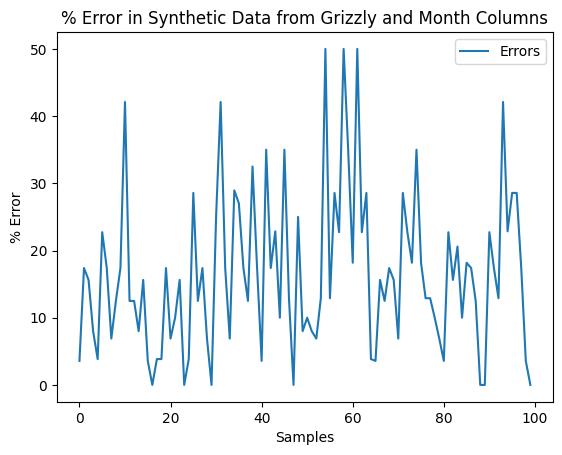

In [42]:
errors = []
for i in range(100):
    synth = dp_synthetic_data_two_marginal('Grizzly', 'Month', 160, 1.0)
    errors.append(pct_error(len(synth[synth['Month'] == 7]), len(bear[bear['Month'] == 7])))


plt.plot(errors, label='Errors')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('% Error')
plt.title('% Error in Synthetic Data from Grizzly and Month Columns')


15

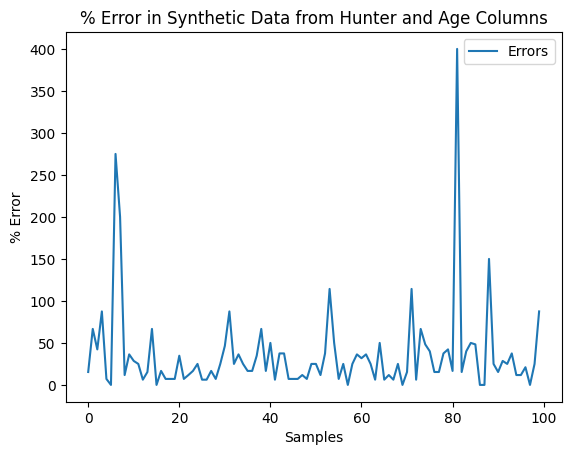

In [43]:
errors = []
for i in range(100):
    synth = dp_synthetic_data_two_marginal('Age', 'Hunter', 160, 1.0)
    errors.append(pct_error(len(synth[synth['Hunter'] == 1]), len(bear[bear['Hunter'] == 1])))


plt.plot(errors, label='Errors')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('% Error')
plt.title('% Error in Synthetic Data from Hunter and Age Columns')
len(bear[bear['Hunter'] == 1])